# Notebook Setup

In [1]:
from IPython.display import clear_output, display
import numpy as np
from scipy import linalg as lin, stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from tqdm import tqdm, trange
from numba import jit
from google.colab.data_table import DataTable
clear_output()

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.show()
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['lines.linewidth'] = 2
np.set_printoptions(suppress=True, precision=4)

In [3]:
def normalize(x):
  x_min = x.min()
  return (x - x_min) / (x.max() - x_min)

def standardize(x):
  return (x - x.mean()) / x.std()

def param_list(text, sep=','):
  text = text.strip()
  return [s.strip() for s in text.split(sep) if s]

# Data Configuration

In [5]:
#@title Download dataset

!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -q --unzip zaheenhamidani/ultimate-spotify-tracks-db

In [6]:
#@title Load dataset

df_spotify = pd.read_csv('SpotifyFeatures.csv')
df_spotify.loc[df_spotify.genre == 'Children’s Music', 'genre'] = 'Children\'s Music'
df_spotify.sample(5, random_state=1)

genre      artist_name  \
166804              Rock      David Bowie   
187633               Ska   Panteon Rococo   
79839              Opera  Giacomo Puccini   
98763   Children's Music     Hot Mulligan   
188563               Ska       Strung Out   

                                               track_name  \
166804                  Starman - 2012 Remastered Version   
187633                                             Perdón   
79839   Puccini: La bohème, Act 1: "Sì. Mi chiamano Mi...   
98763          How Do You Know It’s Not Armadillo Shells?   
188563                                  A War Called Home   

                      track_id  popularity  acousticness  danceability  \
166804  0pQskrTITgmCMyr85tb9qq          74      0.166000         0.486   
187633  0DOlaVxCIgxFXhq4TFJBmr          29      0.226000         0.672   
79839   4tHFwiwI62Wa6xgquB4t2G          17      0.987000         0.228   
98763   019CBVYnVKnSZVHNRnjqkx          48      0.035400         0.691   
188563  4zuVHTYCBbS8SmTv5qsX9V          24      0.000037         0.330   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
166804       254293  0.4500          0.000002   F    0.5400   -10.298  Major   
187633       338267  0.4460          0.001490   C    0.1130   -14.094  Major   
79839        289107  0.0475          0.001230   D    0.1260   -18.715  Major   
98763        163509  0.6410          0.000034  C#    0.0989    -6.947  Major   
188563       200800  0.9890          0.247000   A    0.1540    -3.270  Major   

        speechiness    tempo time_signature  valence  
166804       0.0267  100.456            4/4   0.5500  
187633       0.0471  111.574            4/4   0.7510  
79839        0.0457   90.908            3/4   0.0556  
98763        0.0309  103.975            4/4   0.4220  
188563       0.1060  168.020            4/4   0.2830

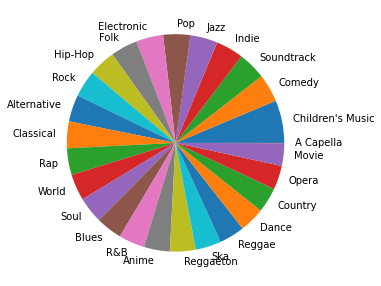

In [7]:
#@title Visualize genres

genres = df_spotify.genre.value_counts().sort_values(ascending=False)

plt.pie(genres, labels=genres.index)
plt.show()

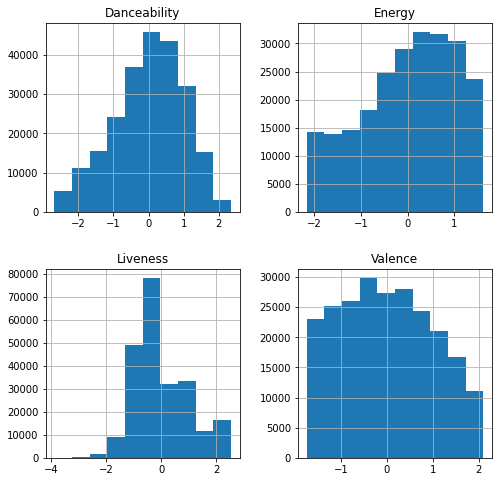

In [8]:
#@title Preprocess dataset

keys = ['danceability', 'energy', 'liveness', 'valence']#, 'popularity'

df = df_spotify[['genre', 'artist_name', 'track_name', 'popularity', *keys]].copy()

# df.genre = df.genre.str.title()

df.liveness = np.log(df.liveness)
# df.speechiness = np.log(df.speechiness)

# import profanity_check
# df['profanity'] = profanity_check.predict_prob(df.song_name.fillna(''))

for key in keys:
  df[key] = standardize(df[key])

df[keys].rename(columns={s: s.title() for s in keys}).hist(figsize=(8, 8))
plt.show()

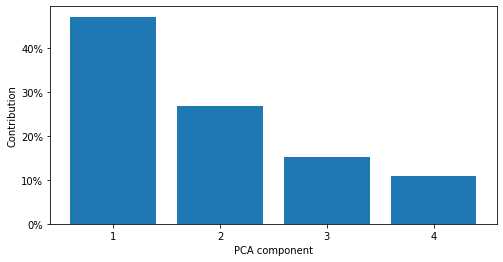

In [9]:
#@title Decompose music features (PCA) {run:'auto'}

from sklearn.decomposition import PCA

pca = PCA(len(keys))

X_pca = pca.fit_transform(df[keys])

n_components = 4 #@param {type:'slider', min:1, max:4, step:1}

pca_contributions = pca.explained_variance_ / pca.explained_variance_.sum() * 100

fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_xlabel('PCA component')
ax.set_ylabel('Contribution')
ax.bar([str(i + 1) for i in range(n_components)], pca_contributions[:n_components])
ax.bar([str(i + 1) for i in range(n_components, len(pca_contributions))], pca_contributions[n_components:], color='lightblue')

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

X_pca = X_pca[:, :n_components]

In [10]:
#@title Define categories {run:'auto'}

from sklearn.cluster import KMeans

# clusters = ['red', 'orange', 'green', 'blue', 'purple', 'teal', 'black']

clusters = 'teal, orange, violet, grey, blue, brown' #@param {type:'string'}
clusters = [s.title() for s in param_list(clusters)]

km = KMeans(n_clusters=len(clusters))
X_km = km.fit_transform(X_pca) # Cluster scores
X_km_norm = (X_km.T / X_km.sum(axis=1).T).T # Normalized cluster scores
X_max = X_km.argmax(axis=1) # Indices of highest scores

X_km_score = X_km_norm ** 2 * 100 # Visual score metric

df['cluster'] = [clusters[i] for i in X_max]
cluster_order = list(df.cluster.value_counts().index)
df.cluster = df.cluster.replace({a: b for a, b in zip(cluster_order, clusters)})

df.cluster.value_counts().to_frame('Songs')

Songs
Teal    134759
Orange   43903
Violet   32454
Grey     21243
Blue       365
Brown        1

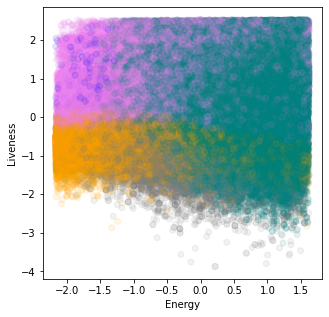

In [11]:
#@title Visualize category influences (features) {run:'auto'}

x_col = 'Energy' #@param ['Danceability', 'Energy', 'Liveness', 'Valence']
y_col = 'Liveness' #@param ['Danceability', 'Energy', 'Liveness', 'Valence']

genre = '' #@param {type:'string'}

df_filter = df[df.genre.str.lower().str.contains(genre.lower())]

plt.figure(figsize=(5, 5))
plt.scatter(*df_filter[[x_col.lower(), y_col.lower()]].values.T, c=df_filter.cluster, alpha=.1)
plt.xlabel(x_col.title())
plt.ylabel(y_col.title())
plt.show()

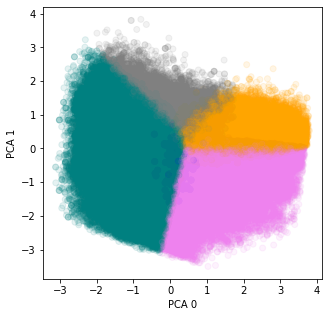

In [12]:
#@title Visualize category influences (PCA components) {run:'auto'}

x_col = 0
y_col = 1

plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, x_col], X_pca[:, y_col], c=df.cluster, alpha=.1)
plt.xlabel(f'PCA {x_col}')
plt.ylabel(f'PCA {y_col}')
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Sankey   [Genre,Cluster]   (Count)
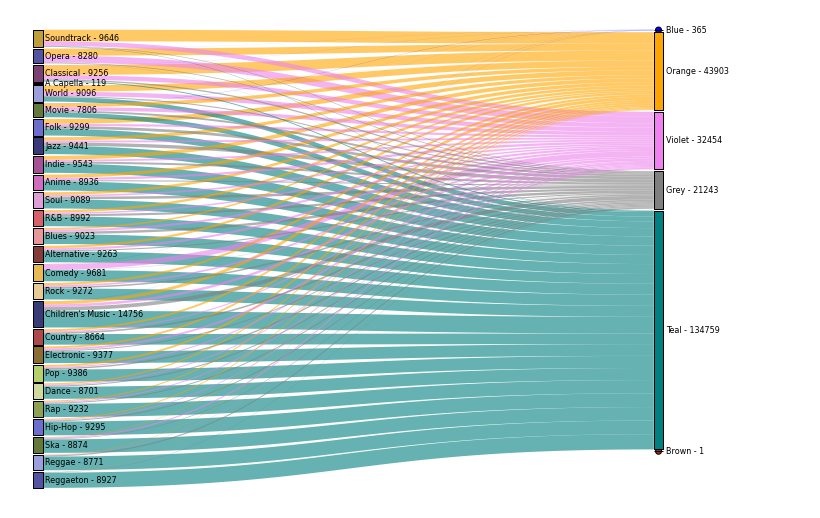

In [13]:
#@title Compare genres to categories {run:'auto'}

import warnings
import matplotlib
import holoviews as hv
hv.extension('matplotlib')

cluster_colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

df_sankey = df.rename(columns={s: s.title() for s in df.columns}).value_counts(['Genre', 'Cluster']).rename('Count').reset_index()

genre_colors = matplotlib.cm.tab20b.colors
cmap = {
    **{cluster: cluster for cluster in df_sankey.Cluster.unique()},
    **{genre: genre_colors[i % len(genre_colors)] for i, genre in enumerate(df_sankey.Genre.unique())},
}

sankey = hv.Sankey(df_sankey)
sankey.opts(edge_color=df_sankey.Cluster, node_color='index', cmap=cmap)
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  display(sankey)

In [14]:
#@title Find examples for a category

category = 'teal' #@param {type:'string'}
category = category.title()

genre = '' #@param {type:'string'}
genre = genre.lower()

df_sample = df[(df.cluster == category) & df.genre.str.lower().str.contains(genre)]
df_sample = df_sample.copy()
df_sample['score'] = [X_km_score[i, cluster_order.index(row.cluster)] for i, row in df_sample.iterrows()]

df_sample[['genre', 'artist_name', 'track_name', 'score']].drop_duplicates(['artist_name', 'track_name']).sort_values('score', ascending=False)[:10]

genre          artist_name                         track_name  \
14625         Dance             James TW                            Soldier   
196672         Soul  Menahan Street Band                 Going The Distance   
149144          Pop   Jillian Jacqueline  If I Were You (feat. Keith Urban)   
158770    Reggaeton             Arcangel                     Mi Primer Kilo   
215314      Country          Josh Turner                    I Saw The Light   
154597         Rock             Survivor                  I Can't Hold Back   
7616        Country          Drake White                       Back To Free   
204596   Soundtrack         John Paesano                        End Credits   
11763   Alternative    The Front Bottoms                     Tie Dye Dragon   
212699      Country        Blake Shelton                             Austin   

           score  
14625   4.768949  
196672  4.729185  
149144  4.718275  
158770  4.710220  
215314  4.705849  
154597  4.703355  
7616    4.700098  
204596  4.695314  
11763   4.694685  
212699  4.689752

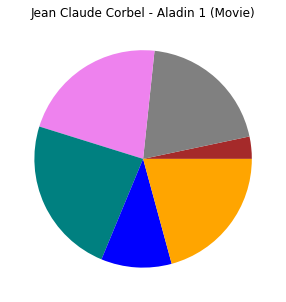

In [15]:
#@title Visualize an individual song {run:'auto'}

song_index = 124 #@param {type:'integer', min:0}

row = df.iloc[song_index]
song_categories = X_km_score[song_index]

plt.title(f'{row.artist_name} - {row.track_name} ({row.genre})')
plt.pie(song_categories, colors=[clusters[cluster_order.index(c)] for c in clusters])
plt.show()

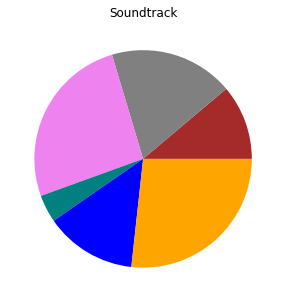

In [16]:
#@title Visualize by genre {run:'auto'}

genre = 'Soundtrack' #@param ["A Capella","Alternative","Anime","Blues","Children's Music","Classical","Comedy","Country","Dance","Electronic","Folk","Hip-Hop","Indie","Jazz","Movie","Opera","Pop","R&B","Rap","Reggae","Reggaeton","Rock","Ska","Soul","Soundtrack","World"]

df_genre = df[df.genre == genre]

song_categories = (X_km_score[df_genre.index]).mean(axis=0)

# plt.figure(figsize=(3, 3))
plt.title(f'{genre}')
plt.pie(song_categories, colors=[clusters[cluster_order.index(c)] for c in clusters])
plt.show()

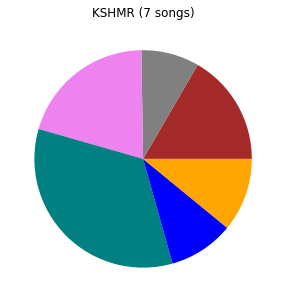

In [17]:
#@title Visualize an artist's style {run:'auto'}

artist = 'kshmr' #@param {type:'string'}

df_artist = df[df.artist_name.str.lower() == artist.lower()]

if len(df_artist):
  song_categories = (X_km_score[df_artist.index]).mean(axis=0)

  plt.title(f'{df_artist.iloc[0].artist_name} ({len(df_artist)} songs)')
  plt.pie(song_categories, colors=[clusters[cluster_order.index(c)] for c in clusters])
  plt.show()

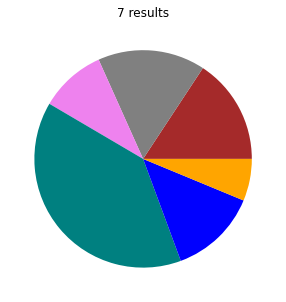

genre                                   track_name  popularity  \
108709   Pop                                Dancing Queen          73   
110440   Pop                          Take A Chance On Me          66   
111250   Pop                                    Mamma Mia          65   
111550   Pop  Gimme! Gimme! Gimme! (A Man After Midnight)          64   
113516   Pop                      The Winner Takes It All          61   
113291   Pop                                Super Trouper          60   
150865   Pop                                     Waterloo          58   

        danceability    energy  liveness   valence  
108709     -0.082779  1.188217  2.154532  1.142340  
110440      0.703824  0.432871  0.317778  1.807557  
111250      1.054024  0.694775  1.412251  1.442264  
111550      1.037861 -0.299700  0.467398  0.300244  
113516     -0.524570  0.812442 -0.920410  0.257947  
113291      1.129452  0.208925  0.102603  1.945984  
150865     -0.610773  1.347636  0.533602  1.246160

In [20]:
#@title Visualize the style of a specific song {run:'auto'}

artist = 'Abba' #@param {type:'string'}
track = '' #@param {type:'string'}

df_search = df[(not artist or df.artist_name.str.lower() == artist.lower()) & (not track or df.track_name.str.lower().str.contains(track.lower(), regex=False))] if artist or track else []

if len(df_search):
  song_categories = (X_km_score[df_search.index]).mean(axis=0)

  plt.title(f'{len(df_search)} result{"s" if len(df_search) != 1 else ""}')
  plt.pie(song_categories, colors=[clusters[cluster_order.index(c)] for c in clusters])
  plt.show()

  x = df_search.sort_values('popularity', ascending=False)[['genre', 'track_name', 'popularity', *keys]]

  display(x)